# Music Box / Transformers2 Lesson Colab


<img src="https://drscotthawley.github.io/blog/posts/images/musicbox_prime.jpeg" width="60%">

This Colab accompanies the blog post ["Understanding Transformers, Part 2: Wee Music Box"](https://drscotthawley.github.io/blog/posts/Transformers2-MusicBox.html") by Scott H. Hawley.

Refer to that post for commentary & exposition.
Here is "just the code" (with comments).

This whole thing executes in under 15 minutes.

## Installs

In [1]:
!sudo apt-get -q install fluidsynth

!pip install -qq gdown==4.6.1 pyfluidsynth pretty_midi torch numpy pandas midi-player multiprocess wandb matplotlib


# Update: Added support for Mamba!
use_mamba = False
if use_mamba:  # Note: mamba-ssm requires CUDA. No CPU or MPS support
    !pip install -q mamba-ssm causal-conv1d

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxc

## Imports

In [2]:
import os
from IPython.display import display, HTML
import collections
import datetime
import fluidsynth
import glob
import pandas as pd
import pretty_midi

import torch
from torch import nn, einsum
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from typing import Optional
from glob import glob
from pathlib import Path
import multiprocess as mp   # multiprocess is a Jupyter-compatible fork of multiprocessing
from functools import partial

from tqdm.notebook import tqdm   # colab gets the shiny progress bars but the text is all mangled
#from tqdm import tqdm  # note: Quarto blog won't print output from tqdm.notebook
from tqdm.contrib.concurrent import process_map  # process_map throws errors on Mac :'-(

import random
import numpy as np
import pprint

from collections import defaultdict
import matplotlib.pyplot as plt

from midi_player import MIDIPlayer
from midi_player.stylers import general, dark # I like dark mode

from dataclasses import dataclass

import wandb

if use_mamba:
    from mamba_ssm import Mamba

## MIDI Dataset Stuff

In [3]:
# READ ALL THE DATA

# Get the data
# jsb chorales may be too small of a dataset for Mamba, which has no dropout

data_source = 'jsb_chorales_midi' # original dataset for this lesson
#data_source = 'maestro' # might be better for testing mamba, but will be slow.

data_dir = Path('midi_data') # generic name for whatever midi data we end up using
REST_PITCH = 127  # special code used to denote rests (stripped out of files, then used as end-of-song token)

if "jsb" in data_source:
    !gdown -O {data_source}.tgz '1MdJiNEgtkvCx9tnyQWcnEE5GPMY6ADUb'
    !tar zxf {data_source}.tgz; rm -rf midi_data; ln -s {data_source} midi_data ;
elif "maestro" in data_source:
    !wget -N https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
    !unzip -n -qq maestro-v3.0.0-midi.zip; rm -rf midi_data; ln -s maestro-v3.0.0 midi_data

# get the list of MIDI filenames
filenames = sorted(glob(str(data_dir/'**/*.mid*'),recursive=True))
print('Number of files:', len(filenames))


Downloading...
From: https://drive.google.com/uc?id=1MdJiNEgtkvCx9tnyQWcnEE5GPMY6ADUb
To: /content/jsb_chorales_midi.tgz
100% 137k/137k [00:00<00:00, 104MB/s]
Number of files: 382


In [4]:

midi_file = filenames[0]
MIDIPlayer(midi_file, 360, styler=dark, title=f"midi_file = {midi_file}")


def quantize_times(times,
                   res_ms=8, # resolution in milliseconds. 8ms was deemed sufficient for MAESTRO.
                   clamp_range_s=[0.0,4.0]):
    "reasonably coarse time quantization is really helpful for facilitating learning temporal behavior"
    quant_step = res_ms / 1000.0
    q_times = torch.round(times / quant_step) * quant_step
    if clamp_range_s is not None:
        q_times = torch.clamp(q_times, clamp_range_s[0], clamp_range_s[1])
    return q_times


def midi_file_to_tensor(filenames, i=None, keep_start_end=False, rest_pitches=[REST_PITCH]):  # filenames could just be a single filename
    midi_file = filenames if i is None or type(filenames)==str  else filenames[i]
    "reads a single midi file and converts it to tensor with elements (pitch, step, duration)"
    pm = pretty_midi.PrettyMIDI(midi_file) # read in the whole file. this can be very slow for long MIDI files (e.g. in MAESTRO)

    # Sort the notes first by start time (and then by pitch if two notes start at the same time)
    sorted_notes = sorted(pm.instruments[0].notes, key=lambda note: (note.start, note.pitch))

    prev_start = sorted_notes[0].start
    notes = []
    for i, note in enumerate(sorted_notes):
        new_note =  torch.empty( (3 + 2*keep_start_end) , dtype=torch.float32)
        if int(note.pitch) in rest_pitches: continue  # we can actually delete the rests!
        new_note[0] = note.pitch
        new_note[1] = note.start - prev_start  # step, i.e. time since start of previous note
        new_note[2] = note.end - note.start    # duration
        if keep_start_end:                     # might find it useful be able to keep these for easier analysis later
            new_note[3] = note.start
            new_note[4] = note.end
        prev_start = note.start
        notes.append(new_note)

    notes = torch.vstack(notes)
    notes[:,1:] = quantize_times(notes[:,1:])
    return notes

notes_tensor = midi_file_to_tensor(midi_file)



def files_to_tensor_list(filenames, keep_start_end=False, parallel=True):
    "Reads MIDI files in parallel so should be reasonably fast. JSB Chorales are no prob but for MAESTRO you want this"
    print("Converting MIDI files to list of tensors...")
    tensor_list = []
    max_ = len(filenames)
    if not parallel:
        for i, filename in enumerate(tqdm(filenames)):
            tensor_list.append(midi_file_to_tensor(filename,  keep_start_end=keep_start_end))
    else:
        #tensor_list = process_map(midi_file_to_tensor, filenames, max_workers=mp.cpu_count(), chunksize=1)
        print("parallel execution")
        with mp.Pool(processes=mp.cpu_count()) as p:
            with tqdm(total=max_) as pbar:
                for r in p.imap_unordered(partial(midi_file_to_tensor, filenames, keep_start_end=keep_start_end), range(0, max_)):
                    tensor_list.append(r)
                    pbar.update()
    return  tensor_list




notes_tensor_list_filename = f'{data_source}_tensor_list.pt'  # we'll save the result to a file for quicker re-reading next time
read_all_midi_files = not os.path.exists(notes_tensor_list_filename) # check to see if it already exists

if read_all_midi_files:
    notes_tensor_list = files_to_tensor_list(filenames)
    torch.save(notes_tensor_list, notes_tensor_list_filename) # save for next time
else:
    notes_tensor_list = torch.load(notes_tensor_list_filename) # just read from the last time we made one

print(f"\nlen(notes_tensor_list) = {len(notes_tensor_list)}")

notes_tl = notes_tensor_list
all_notes = torch.vstack(notes_tl).type(torch.float32)
print("all_notes.shape = ",all_notes.shape)



Converting MIDI files to list of tensors...
parallel execution


  0%|          | 0/382 [00:00<?, ?it/s]


len(notes_tensor_list) = 382
all_notes.shape =  torch.Size([78349, 3])


In [5]:
# ENCODE & DECODE THE DATA

def make_codebooks(all_notes, verbose=False):
    codebooks = []
    n_codebooks = all_notes.shape[-1] # = 3 for pitch, step, duration
    for i in range(n_codebooks):
        if i==0:  # i=0 means pitch
            cb_vals = torch.arange(128)  # just use all possible pitches. could limit to min/max range but...not gonna.
        else:     # i!=0 means timing
            cb_vals = all_notes[:,i].unique().sort()[0]
        if verbose: print(f"\n---\ncb {i}: cb_vals = {cb_vals}")
        codebooks.append(cb_vals)
    return codebooks


all_notes[:,1:] = quantize_times(all_notes[:,1:]) # we should already be time-quantized so this should be unnecessary, but...just in case
codebooks = make_codebooks(all_notes, verbose=False)

vocab_sizes = [len(cb) for cb in codebooks]
display(HTML(f"Codebook sizes = {vocab_sizes}<br><br>"))


###--- From here down, it's just a nice way to display the codebooks in the blog post:

df1 = pd.DataFrame(codebooks[1].numpy(), columns=['steps (s)'])
df2 = pd.DataFrame(codebooks[2].numpy(), columns=['durations (s)'])
display(HTML(f"Codebooks for steps & durations are {'' if df1.equals(df2) else 'not '}the same:"))

html1, html2 = df1.to_html(index=False),  df2.to_html(index=False)

# Combine HTML strings with a space in between
combined_html = f'''<div style="width: 100%; text-align: center;">
     <table style="margin-left: auto; margin-right: auto;"> <tr>
     <td style="vertical-align: top;">{html1}</td>
     <td style="width: 50px;"></td>
     <td style="vertical-align: top;">{html2}</td>
     </tr></table></div>'''

# Display the combined HTML
display(HTML(combined_html))




def encode_one_cb(seq:torch.Tensor, cb:torch.Tensor) -> int:
    """ Encodes one 'column' of note info (either pitches, steps, or durations)
        given new value(s) and codebook, return argmin of the difference
        Difficulty: seq and cb may have different lengths & may not broadcast,
        thus I wrote a loop that broadcasts each note over all cb values
    """
    sidx = torch.empty( seq.shape, dtype=int, device=seq.device)
    for i, note in enumerate(seq):                          # note: this is trivially parallel but jupyter mp hangs for me :'-(
        sidx[i] = torch.argmin( ( note - cb )**2, dim=0 )   # could use torch.abs() instead of ^2 since we're in 1-D, but I want this to be general
    return sidx

def decode_one_cb(xi, cb:torch.Tensor) -> torch.Tensor:
    """Decodes one 'column' of note-index info (either pitch_i, step_i, or duration_i)
    xi should be an int, a list of ints, or a tensor of ints"""
    return cb[xi]

def encode(seq:torch.Tensor, cbs=codebooks) -> torch.Tensor:
    "Encodes a sequence of notes, where each note is (pitch, step, dur)"
    assert len(seq.shape) == 2, "Not set up for batch processing yet, but could be a fun exercise for a student ;-) "
    encoded = torch.empty( seq.shape, dtype=int, device=seq.device)
    for i, cb in enumerate(cbs):
        encoded[:,i] = encode_one_cb( seq[:,i], cb)
    return encoded

def decode(sidx:torch.Tensor, cbs=codebooks) -> torch.Tensor:
    "Decodes a sequence of integer indices for notes (pitch_i, step_i, dur_i)"
    assert len(sidx.shape) == 2, "Not set up for batch processing yet, but could be a fun exercise for a student ;-)"
    decoded = torch.empty( sidx.shape, dtype=torch.float32, device=sidx.device)
    for i, cb in enumerate(cbs):
        decoded[:,i] = decode_one_cb( sidx[:,i], cb)
    return decoded



# Let's do a little test to see if we get back what we encode
midi_seq = all_notes[0:8].clone()
print("Before encoding, midi_seq =\n",midi_seq)
token_list = encode(midi_seq)
print("After encoding, token_list =\n",token_list)
return_seq = decode(token_list)
print("After decoding, return_seq =\n",return_seq)
assert torch.equal( midi_seq, return_seq), f"Oops. midi_seq={midi_seq}, but return_seq={return_seq}. Should be the same"

# "safety" check re. values that exceed codebook range -- should get truncated to last cb entry
midi_seq[-1,-1] = 100.0  # give the last time a huge value to check that our mapper won't crash
token_list = encode(midi_seq, codebooks) # if it doesn't crash, we're good
assert token_list[-1,-1] == len(codebooks[-1])-1, f"Big value ({midi_seq[-1,-1]}) should have gotten the last spot in the last codebook ({len(codebooks[-1])-1}) but came back as {token_list[-1,-1]}"

print("Preliminary Encoding/Decoding checks pass! :-)")



def get_start_end(notes:torch.Tensor) -> torch.Tensor:
    "integrates (step,duration) timing pairs to recover (start,end) info. concats them as new columns"
    newnotes = torch.zeros((len(notes), 5), dtype=notes.dtype, device=notes.device)
    newnotes[:,:3] = notes[:,:3]
    prev_start = 0.0
    for i, note in enumerate(notes):
        step, dur = note[1], note[2]
        start = step  + prev_start
        end   = start + dur
        newnotes[i,3], newnotes[i,4] = start, end
        prev_start = start
    return newnotes


def notes_to_midi(notes:torch.Tensor,
                  time_rescale=None,
                  out_file: str = '',
                  instrument_name: str = 'Acoustic Grand Piano',
                  velocity: int = 64,  # default loudness for all notes
                 ) -> pretty_midi.PrettyMIDI:
    notes = notes.clone() # just to avoid weird overwrites of memory addresses
    if notes.min() < 0.0:
      print("WARNING: You have negative pitches, steps or durations. Setting them to zero")
      notes = notes * (notes >= 0)
    if time_rescale is not None: # just added this because sometime I want to slow/speed up
        notes[:,1:] = notes[:,1:] *time_rescale

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))

    if notes.shape[-1] < 5: notes = get_start_end(notes)

    notes = notes.cpu().numpy()
    prev_start = 0.0
    for note in notes:
        pitch, start, end = int(note[0]), note[3], note[4]
        midi_note = pretty_midi.Note( velocity=velocity, pitch=pitch, start=start, end=end, )
        instrument.notes.append(midi_note)
        prev_start = start

    pm.instruments.append(instrument)
    if out_file: pm.write(out_file)
    return pm



def midiplayer(notes_tensor, height=400, time_rescale=None, midi_file="/tmp/tmp.mid", title='', styler=dark):
    "MIDIplayer that writes input tensor to temporary file"
    pm = notes_to_midi(notes_tensor, time_rescale=time_rescale, out_file=midi_file)
    return MIDIPlayer(midi_file, height, styler=dark, dl=True, title=title)

midiplayer(decode(encode(midi_file_to_tensor(filenames[0]))), title='Encode-Decode Test')



# tensor lists
if 'jsb' in data_source:
    train_filenames = [x for x in filenames if '/train' in x]
    val_filenames   = [x for x in filenames if '/val'   in x]
    test_filenames  = [x for x in filenames if '/test'  in x]
    train_notes_tl = files_to_tensor_list(train_filenames)
    val_notes_tl   = files_to_tensor_list(val_filenames)
    test_notes_tl  = files_to_tensor_list(test_filenames)
elif 'maestro' in data_source:
    splits = [int(s*len(filenames)) for s in [0.8,0.9]]
    train_notes_tl = notes_tensor_list[:splits[0]]
    val_notes_tl = notes_tensor_list[splits[0]:splits[1]]
    test_notes_tl = notes_tensor_list[splits[1]:]
else:
    assert False, f"Unsupported data_source = {data_source}"

for name, tl in zip(['train','val','test'],[train_notes_tl, val_notes_tl, test_notes_tl]):
    stack = torch.vstack(tl)
    print(f"{len(tl)} songs in {name}, {stack.shape[0]} notes")




steps (s)
0.00
0.12
0.24
0.36
0.48
0.72
0.96
1.20
1.44
1.68


Before encoding, midi_seq =
 tensor([[53.0000,  0.0000,  0.4800],
        [57.0000,  0.0000,  0.4800],
        [60.0000,  0.0000,  1.4400],
        [65.0000,  0.0000,  0.4800],
        [52.0000,  0.4800,  0.4800],
        [55.0000,  0.0000,  0.4800],
        [72.0000,  0.0000,  0.2400],
        [70.0000,  0.2400,  0.2400]])
After encoding, token_list =
 tensor([[53,  0,  3],
        [57,  0,  3],
        [60,  0, 11],
        [65,  0,  3],
        [52,  4,  3],
        [55,  0,  3],
        [72,  0,  1],
        [70,  2,  1]])
After decoding, return_seq =
 tensor([[53.0000,  0.0000,  0.4800],
        [57.0000,  0.0000,  0.4800],
        [60.0000,  0.0000,  1.4400],
        [65.0000,  0.0000,  0.4800],
        [52.0000,  0.4800,  0.4800],
        [55.0000,  0.0000,  0.4800],
        [72.0000,  0.0000,  0.2400],
        [70.0000,  0.2400,  0.2400]])
Preliminary Encoding/Decoding checks pass! :-)
Converting MIDI files to list of tensors...
parallel execution


  0%|          | 0/229 [00:00<?, ?it/s]

Converting MIDI files to list of tensors...
parallel execution


  0%|          | 0/76 [00:00<?, ?it/s]

Converting MIDI files to list of tensors...
parallel execution


  0%|          | 0/77 [00:00<?, ?it/s]

229 songs in train, 46660 notes
76 songs in val, 15052 notes
77 songs in test, 16637 notes


In [6]:

# MAKE THE DATASET

def augment_data(data, pitch_shift=12, debug=True, extra_augs=False):
    datanew = data.clone()                                     # avoid overwriting memory of data
    # pitch
    change = torch.randint(-pitch_shift, pitch_shift, (1,))    # how many semitones to change all the pitches
    datanew[ datanew[:,0] != REST_PITCH ] += torch.tensor((change, 0, 0))  # change the pitches
    if not extra_augs: return datanew   #only do pitches

    if torch.rand(1) < 0.2:                         # sometimes invert pitches? Probably not useful but anyway
        datanew[ datanew[:,0] != REST_PITCH ] *= torch.tensor((-1, 1, 1))
        datanew[ datanew[:,0] != REST_PITCH ] += torch.tensor((127, 0, 0))

    # time - if we sometimes increase each non-zero time-token by one, that should be ok, right?
    if torch.rand(1) < 0.2: # do step
        datanew[ datanew[:,1] > 0]  += torch.tensor((0,1,0))
    if torch.rand(1) < 0.2: # do duration
        datanew[ datanew[:,2] > 0]  += torch.tensor((0,0,1))

    # extra 'safety' constraint: clamp to range of valid values (of tokens)
    for i, cb in enumerate(codebooks):
        datanew[:,i] = torch.clamp(datanew[:,i], 0, len(cb['encode'])-1)
    return datanew


# testing augmentation:
torch.manual_seed(3) # setting this just  to make sure something happens ;-)
data = torch.tensor([[54,12,6],[61,0,40],[127,14,4],[86,0,12],[126,7,12]])
print("data.shape = ",data.shape)
print("original data = \n",data)
aug = augment_data(data)
print("augmented data = \n",aug) #

assert not torch.equal(aug[:,0], data[:,0]), "Oops, nothing changed"
assert aug[2,0]==data[2,0], "Oops,  The 127 got changed"
print("Checks passed! :-) ")


class NotesDataset(Dataset):
    "simple custom dataset of sliding windows"
    def __init__(self,
                 tensor_list,
                 seq_length:int,
                 tokenizer=encode,
                 codebooks=codebooks,
                 aug_callback=augment_data,
                 len_mult=100,  # factor to 'fudge' the dataset length when it's inspected by DataLoaders
                 pad=True, # pad end with rests
                ):
        super().__init__()
        self.sl = seq_length
        self.len_mult = len_mult
        print("Encoding dataset into ints...")
        #self.data_list = [tokenizer(t) for t in tqdm(tensor_list)] # encoded tokens are all we'll use
        self.data_list = process_map(tokenizer, tensor_list, max_workers=mp.cpu_count(), chunksize=1)

        if pad:
            rests = torch.tensor([REST_PITCH,1,1]).unsqueeze(0).tile((seq_length,1))
            self.data_list = [torch.cat((toks,rests), dim=0) for toks in self.data_list]
        self.aug_callback = aug_callback

    def __len__(self):
        """we're going to be grabbing random windows from the data, so just the len of the tensor
        list will be too small for large batch sizes, hence we multiply by len_mult"""
        return len(self.data_list)*self.len_mult  # this will keep the DataLoader going longer

    def __getitem__(self, idx, shift=1) -> (torch.Tensor, torch.Tensor):
        "grabs a random 'window' from a random song, with an offset of `shift` tokens between inputs and targets"
        i_song = torch.randint(0, len(self.data_list), (1,)) # pick a song
        ix =  torch.randint(0, len(self.data_list[i_song]) - self.sl - 1, (1,))  # start of window within song
        data_block = self.data_list[i_song][ix:ix+self.sl+1]  # grab window plus an extra character
        if self.aug_callback is not None:
            data_block = self.aug_callback(data_block)
        inputs, targets = data_block[:self.sl], data_block[shift:self.sl+shift]
        return inputs, targets


seq_length = 64
train_ds = NotesDataset(train_notes_tl, seq_length)
val_ds = NotesDataset(val_notes_tl, seq_length, aug_callback=None, len_mult=1000000) # no aug, neverending
# save test_ds for Evaluation section, later
len(train_ds), len(val_ds)


batch_size = 128 # We may change this further down, for now it's just a test
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, )

batch_x, batch_y = next(iter(train_dl))
print("batch_x.shape, batch_y.shape = ",batch_x.shape, batch_y.shape)


data.shape =  torch.Size([5, 3])
original data = 
 tensor([[ 54,  12,   6],
        [ 61,   0,  40],
        [127,  14,   4],
        [ 86,   0,  12],
        [126,   7,  12]])
augmented data = 
 tensor([[ 52,  12,   6],
        [ 59,   0,  40],
        [127,  14,   4],
        [ 84,   0,  12],
        [124,   7,  12]])
Checks passed! :-) 
Encoding dataset into ints...


  0%|          | 0/229 [00:00<?, ?it/s]

Encoding dataset into ints...


  0%|          | 0/76 [00:00<?, ?it/s]

batch_x.shape, batch_y.shape =  torch.Size([128, 64, 3]) torch.Size([128, 64, 3])


## Hyperparam stuff

In [7]:
@dataclass
class MusicBoxConfig:
    # model architecture details
    seq_length: int = 64
    batch_size: int = 128
    n_embd:     int = 128     # embedding dimension to use for tokens & positions
    n_heads:    int = 8       # number of attention heads
    n_blocks:   int = 4       # number of attention blocks
    dropout:  float = 0.1     # dropout value applied everywhere
    bias:      bool = False   # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    use_alibi: bool = False   # use ALiBi for/instead of PE
    use_mamba: bool = use_mamba  # this gets set near the top of this notebook

    # training details
    learning_rate: float = 0.001
    weight_decay:  float = 0.01   # 0.01 is pytorch default
    epochs:          int = 20

    # other handy bookkeeping
    vocab_sizes: tuple = tuple(vocab_sizes)



@dataclass
class MonsterConfig:  # "Monster" size model ;-)
    # model architecture details
    seq_length: int = 128
    batch_size: int = 256
    n_embd:     int = 256
    n_heads:    int = 16
    n_blocks:   int = 8
    dropout:  float = 0.1
    bias:      bool = False
    use_alibi: bool = False
    use_mamba: bool = use_mamba  # this gets set near the top of this notebook

    # training details
    learning_rate: float = 0.001
    weight_decay:  float = 0.1 # 0.1 for Mamba  ,  0.04 for regular Transformer
    epochs:          int = 12

    # other handy bookkeeping
    vocab_sizes: tuple = tuple(vocab_sizes)

config = MusicBoxConfig()
#config = MonsterConfig()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(config)


MusicBoxConfig(seq_length=64,
               batch_size=128,
               n_embd=128,
               n_heads=8,
               n_blocks=4,
               dropout=0.1,
               bias=False,
               use_alibi=False,
               use_mamba=False,
               learning_rate=0.001,
               weight_decay=0.01,
               epochs=20,
               vocab_sizes=(128, 15, 28))


## Transformer Code

In [8]:
# from my mod of Karpathy's code.

# Unless otherwise noted, anything good in what follows was pasted
# from https://github.com/karpathy/minGPT and adapted by Scott H. Hawley (SHH)


def create_alibi_mask(n):
    "SHH: added this after the fact to demo ALiBi support"
    mat = torch.zeros((n, n))

    # Iterate over the lower triangular indices (excluding the diagonal)
    for i in range(1, n):
        for j in range(i):
            mat[i, j] = -(i - j)

    # Create a mask for the upper triangular part, excluding the diagonal
    mask = torch.triu(torch.ones_like(mat), diagonal=1)

    mat[mask.bool()] = float('-inf') # Apply mask, set upper triangular -inf
    return mat


class Head(nn.Module):
    """ one head of self-attention
        SHH: Note: Often Multi-head Attention is done all at once via one big matrix multiply,
                   but Karpathy (perhaps for reasons of clarity or to keep VRAM usage low)
                   implemented each Head separately and then looped over them.
    """
    def __init__(self, head_size, config):
        super().__init__()
        n_embd, block_size = config.n_embd, config.seq_length
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.use_alibi = config.use_alibi
        if self.use_alibi:
            self.register_buffer('alibi', create_alibi_mask(block_size))
        else:
            self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        if self.use_alibi:
            wei = wei + self.alibi[:T,:T]
        else:
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel
        SHH: As noted above, typically MHA is one big matmul (as in my original code),
             but Karpathy looped over heads so we'll do that.
    """
    def __init__(self, num_heads, head_size, config):
        super().__init__()
        n_embd = config.n_embd

        self.heads = nn.ModuleList([Head(head_size, config) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """ Transformer block: communication followed by computation
        SHH: Note: The ordering of the LayerNorm ops has differed in different Transformer implementations
                   Some have pointed out that the original Transformer architecture diagram didn't match the code
    """

    def __init__(self, n_embd, n_head, config):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        if not config.use_mamba:
            self.sa = MultiHeadAttention(n_head, head_size, config)
        else:
            self.sa = Mamba( # Attribution: u/ExaminationNo8522 @ https://www.reddit.com/r/MachineLearning/comments/18d65bz/d_thoughts_on_mamba/
                # This module uses roughly 3 * expand * d_model^2 parameters
                d_model=n_embd, # Model dimension d_model
                d_state=16,  # SSM state expansion factor
                d_conv=4,    # Local convolution width
                expand=2,    # Block expansion factor
            ).to("cuda")

        self.ffwd = FeedFoward(n_embd, config)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class Transformer(nn.Module):
    """  Main Transformer class, from Karpathy's "BigramLanguageModel" class.
         SHH added the looping over multiple codebooks / vocabs
    """
    def __init__(self, config, debug=False):
        super().__init__()
        n_cb = len(config.vocab_sizes)
        self.block_size, n_embd, n_head, n_layer, self.use_alibi = config.seq_length, config.n_embd, config.n_heads, config.n_blocks, config.use_alibi

        # seperate embeddings for pitch, step & dur part of notes
        self.token_embedding_tables = nn.ModuleList([nn.Embedding(vocab_sizes[cbi], n_embd) for cbi in range(n_cb)])
        if not config.use_alibi: self.position_embedding_table = nn.Embedding(self.block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, config) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_heads = nn.ModuleList([nn.Linear(n_embd, vocab_sizes[cbi]) for cbi in range(n_cb)]) # output token predictors
        self.debug=False

    def forward(self, idx, targets=None):
        # idx is array of input token indices in the current context
        B, T, CBS = idx.shape

        tok_emb = 0
        for cb in range(CBS): # just sum codebook reps
            tok_emb = tok_emb + self.token_embedding_tables[cb](idx[:,:,cb])
        x = tok_emb
        if not self.use_alibi:
            pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device)) # (T,E)
            x = x + pos_emb    #  sum token embeddings & positional embeddings

        x = self.blocks(x) # Main computation loop!
        x = self.ln_f(x)   # final layernorm
        logits_list = [head(x) for head in self.lm_heads]  # list of output projections over all codebook values

        if targets is None:  # need targets to compute loss
            loss = None
        else:
            lambdas = [0.5]*CBS   # relative "weights" to pitch, step, dur parts of loss. TODO: Should be in config as hyperparams
            loss = 0.0
            for cb in range(CBS):        # loop over codebooks  (for pitch, step & dur), summing loss
                logits = logits_list[cb]
                B, T, V = logits.shape   # V = vocab size, i.e. codebook length
                targ = targets[:,:,cb]   # B, T
                logits = logits.view(B*T, V)
                targ = targ.reshape(B*T)    # needs reshape & not view b/c of contiguous memory issues.
                loss = loss +  lambdas[cb] * F.cross_entropy(logits, targ)
        return logits_list, loss


    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0):
        # idx is (B, T, CBS) array of token indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]      # crop idx to the last block_size tokens
            logits_list, loss = self(idx_cond)   # get the predictions
            idx_next_list = []
            for cb in range(idx_cond.shape[-1]):
                # focus only on the last time step
                logits = logits_list[cb]  # B, T, V  where V = vocab/embedding size
                logits = logits[:, -1, :] # get last time.  becomes (B, V)
                # apply softmax to get probabilities
                probs = F.softmax(logits/temperature, dim=-1) # (B, V)
                # sample from the distribution
                idx_next_list.append(torch.multinomial(probs, num_samples=1)) # (B, 1)

            idx_next = torch.tensor(idx_next_list).unsqueeze(0).unsqueeze(0).to(idx.device)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


# test that, make sure we don't get any errors:
model = Transformer(config)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters in the model')

0.843947 M parameters in the model


## Stuff Before Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("device is",device)


demo_prompt_idx = 0    # file index from which to pull the demo prompt
demo_target = val_notes_tl[demo_prompt_idx]
display(midiplayer(demo_target, title=f"Full demo 'target', {len(demo_target)} notes in length"))

demo_prompt_length = 16  # number of notes in demo prompt context
demo_max_new_tokens = min(150, len(demo_target))  # try to make the whole song, but don't go on too long
prompt = demo_target[:demo_prompt_length]
display(midiplayer(prompt, title=f"{demo_prompt_length}-note 'prompt' for demos"))
prompt_tokens = encode(prompt).unsqueeze(0).to(device)

#  set RNG seeds for reproducibility.
def set_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seeds(0)

if 'maestro' not in data_source: # skip this 'reproducibility' for maestro it takes too long.
    train_ds = NotesDataset(train_notes_tl, config.seq_length, len_mult=config.batch_size)
    val_ds = NotesDataset(val_notes_tl, seq_length, aug_callback=None, len_mult=1000000) # no aug, neverending

    train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=config.batch_size, shuffle=False)

model = Transformer(config)
model = model.to(device)
total_params_str = f'{sum(p.numel() for p in model.parameters())/1e6} M'
print(total_params_str,'parameters in the model')

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)


device is cuda


Encoding dataset into ints...


  0%|          | 0/229 [00:00<?, ?it/s]

Encoding dataset into ints...


  0%|          | 0/76 [00:00<?, ?it/s]

0.843947 M parameters in the model


## Want WandB?

In [10]:
# wandb stuff

use_wandb = False  # Tip: leave this off at first, until you're sure everything's working!
if use_wandb:
    wandb.login()
    wandb.init(project=f"musicbox-{data_source}", config=config)

# Training stuff

In [ ]:

val_every  = 1 # in steps, evaluate loss on val dataset
cp_every   = 60 # in epochs, checkpoint every
demo_every = 4 # in epochs, make a midi player demo

best_loss = 999

ema_weight, loss_ema, val_loss_ema = 0.95, None , None # exponential moving averages for loss reporting
step = 0
losses = {}
epochs = config.epochs
for epoch in range(1,epochs+1):
    pbar = tqdm(total=len(train_dl), desc=f"Epoch {epoch}/{config.epochs}", dynamic_ncols=False, ncols=100) # progress bar, per epoch
    for bi, batch in enumerate(train_dl):
        step += 1
        xb, yb = batch[0].to(device), batch[1].to(device)

        logits, loss = model(xb, yb) # evaluate the loss
        loss_ema = (1.0-ema_weight)*loss.item() + ema_weight*loss_ema if loss_ema is not None else loss.item()
        losses['train'], losses['train_ema'] = loss.item(), loss_ema
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if config.use_mamba:
            torch.nn.utils.clip_grad_value_(model.parameters(), 0.1) # from mamba paper, for audio

        optimizer.step()

        # status / diagnostics:
        if (step % val_every == 0):
            with torch.no_grad():
                model.eval()
                xvb, yvb = next(iter(val_dl))
                val_logits, val_loss = model( xvb.to(device), yvb.to(device) )
                val_loss_ema =  (1.0-ema_weight)*val_loss.item() + ema_weight*val_loss_ema if val_loss_ema is not None else val_loss.item()
                losses['val'], losses['val_ema'] = val_loss.item(), val_loss_ema
            model.train()

        wbl_dict = {'step':step, 'epoch':epoch} | losses   # dict for logging losses, midi examples, etc to wandb
        pbar.set_postfix( dict((k,losses[k]) for k in ['train', 'val','val_ema'])) # loss info for progress bar
        pbar.update(1)
        if use_wandb and wbl_dict != {}: wandb.log(wbl_dict)

    #--- end of epoch ---

    if losses['val_ema'] < best_loss: # Tracking best val_loss_ema for checkpointing purposes
        best_loss = losses['val_ema']
        pbar.set_postfix(dict( (k,losses[k]) for k in ['train', 'val']) | {'BEST val_ema':best_loss})
        if (epoch) % cp_every==0:   # occasionally save a checkpoint of best model/optimizer states
            cp_file = f"musicbox-jsb" #    -{step}" # let's leave out step to avoid filling disk
            print(f"Saving a checkpoint to {cp_file}")
            torch.save({ 'step': step, 'model_state_dict': model.state_dict(), 'loss': loss,
                         'optimizer_state_dict': optimizer.state_dict(),}, cp_file)
    pbar.refresh()
    pbar.close()

    if (epoch % demo_every == 0) or (epoch==epochs):  # demo of midi generation
        with torch.no_grad():
            model.eval()
            new_notes = decode( model.generate(prompt_tokens, max_new_tokens=demo_max_new_tokens, temperature=1)[0].cpu() )
            p2 = midiplayer(new_notes,title=f"Demo on val dataset, Epoch={epoch}")
            display(p2)
            if use_wandb: wandb.log( {'step':step, 'player':wandb.Html(p2.html)} )
        model.train()


Epoch 1/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 2/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 3/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 4/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 5/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 6/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 7/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 8/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 9/20:   0%|                                                           | 0/229 [00:00<?, ?it/s]

Epoch 10/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

Epoch 11/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

Epoch 12/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

Epoch 13/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

Epoch 14/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

Epoch 15/20:   0%|                                                          | 0/229 [00:00<?, ?it/s]

In [ ]:
if use_wandb: wandb.finish()

## Evaluation Stuff

In [19]:
# gen samples

file_ind = 1
original = test_notes_tl[file_ind]
num_tokens = len(original)
display(midiplayer(original, title=f"Full Evaluation Target, {num_tokens} notes long"))


prompt_len = 21
prompt = original[:prompt_len]
display(midiplayer(prompt, title=f"Evaluation Prompt, {prompt_len} notes long"))

prompt_tokens = encode(prompt).unsqueeze(0).to(device)

new_tokens = num_tokens - prompt_len

for temperature in [ 0.7, 0.85, 0.92, 1.0, 1.2, 1.5]:
    set_seeds(1337) # same temp for same seed will yield same output
    notes = decode( model.generate(prompt_tokens, max_new_tokens=new_tokens, temperature=temperature)[0].cpu() )
    display(midiplayer(notes, title=f"Temperature = {temperature}"))


In [20]:
# perplexity

test_ds = NotesDataset(test_notes_tl, config.seq_length, len_mult=config.batch_size, pad=False)
test_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=False)

total, batches = 0, 0
with torch.no_grad():
    model.eval()
    for i, batch in enumerate(tqdm(test_dl, ncols=100)):
        batches +=1
        xb, yb = [q.to(device) for q in batch]
        logits, loss = model(xb, yb)
        total = total + loss.cpu().item()
perplexity = np.exp(total/batches)
print(f"(Average) Perplexity = {perplexity:5.3f}")



Encoding dataset into ints...


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|                                                                       | 0/229 [00:00<?, ?it/s]

(Average) Perplexity = 2.410


Generating new notes...


  0%|                                                                        | 0/77 [00:00<?, ?it/s]

# of test notes = 4159,  # of generated notes = 4158 --- Close enough!


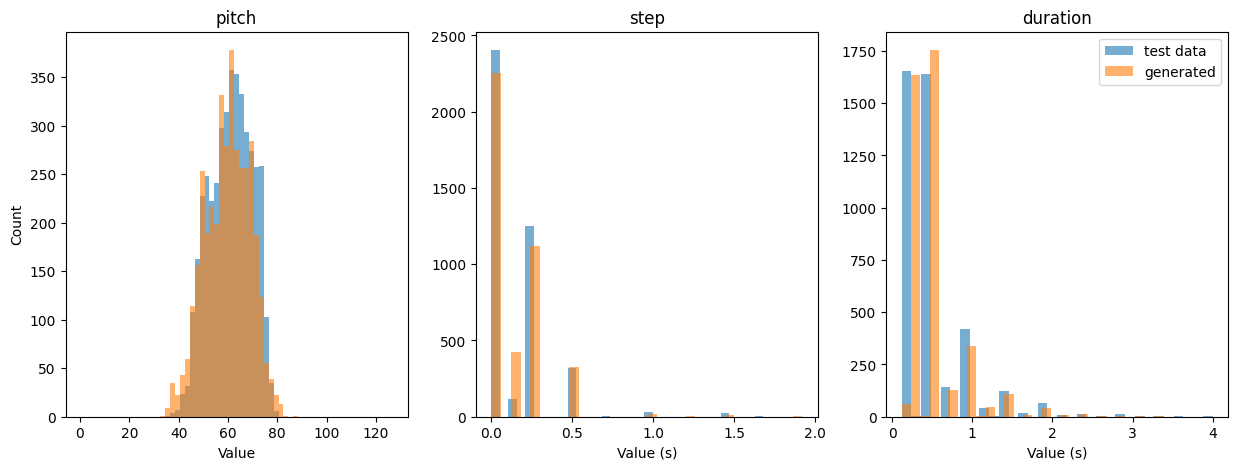

In [21]:
#stats

all_test_notes = torch.vstack(test_notes_tl).type(torch.float32)
all_test_notes = all_test_notes[:len(all_test_notes)//4]  # to save time, let's not do stats on ALL-all of them, just a quarter

# generate a big batch of fake data.
# WARNING: this is super slow because our generator only works for batches of one, oops
prompt_len, max_new_tokens = 12, 54          # I just made these numbers up. not great science yet, sorry.
new_notes_list = []
print("Generating new notes...")
for i, notes in enumerate(tqdm(test_notes_tl, ncols=100)):
    ptoks = encode(notes[:prompt_len]).unsqueeze(0).to(device)
    # generate more notes, chop off prompt before adding to list of all generated notes
    new_notes_list.append( decode( model.generate(ptoks, max_new_tokens=max_new_tokens)[0].cpu()[prompt_len:] ) )
all_new_notes = torch.vstack(new_notes_list).type(torch.float32)

print(f"# of test notes = {len(all_test_notes)},  # of generated notes = {len(all_new_notes)} --- Close enough!")


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
names = ['pitch', 'step', 'duration']
for i in range(3):
    bins = 32 if i !=0 else 0.5 + 2*np.arange(128//2)
    ax[i].hist(all_test_notes[:,i].numpy(), bins=bins, label='test data', alpha=0.6)
    ax[i].hist(all_new_notes[:,i].numpy(),  bins=bins, label='generated', alpha=0.6)
    ax[i].set_title(names[i])
    if i==2: ax[i].legend()
    ax[i].set_xlabel('Value'+f'{" (s)" if i>0 else ""}')
    if i==0: ax[i].set_ylabel('Count')
plt.show()

Appendix:

If you want the Christmas stuff, just do "show code" in the blog post.

----
This work is MIT-licensed by Scott H. Hawley. Feel free to use it as you like, but an attribution would be nice.


# ADDENDUM: Inference-Time "Conditioning"/Control of Pretrained Transformer

We're going to add a control parameter to "strongly suggest" to the *pretrained* model that only output in certain keys, by adjusting the probabilities of notes during inference time.

i.e., we're only going to modify the "generate" part of the code!

Note that this is going to "suck" a bit in that I'm not altering the key of the "prompt", so you'll hear an abrupt transition, and the model will struggle at first while it tries to combine two keys into one!

In [68]:
def get_key_logits(key:str, strength=1.0):
    "assign initial logits for all the preferred notes for the given (major) key"
    # A0 is MIDI node 21, C1 is 24: https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies
    # first do one octave
    key_logits = torch.zeros(128)
    if key is not None:
        tonic_ind_0 = 24 + ['C','D','E','F','G','A','B',].index(key.upper())
        #key_inds = tonic_ind0 + torch.tensor([0,2,3,5,7,9,11]) # major key notes in semitones
        key_logits_0 = strength*torch.tensor([1.1,0,1,1,0,1.1,0,1.1,0,1,0,1]) # make tonic & 5th strongest

        # then copy to other octaves up to including C8
        for octave in range(0,8):
            start = tonic_ind_0 + octave*12
            key_logits[start:start+12] = key_logits_0
    return key_logits

kl = get_key_logits('A')
kl

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.1000, 0.0000, 1.0000, 1.0000, 0.0000, 1.1000, 0.0000,
        1.1000, 0.0000, 1.0000, 0.0000, 1.0000, 1.1000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.1000, 0.0000, 1.1000, 0.0000, 1.0000, 0.0000, 1.0000, 1.1000,
        0.0000, 1.0000, 1.0000, 0.0000, 1.1000, 0.0000, 1.1000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.1000, 0.0000, 1.0000, 1.0000, 0.0000, 1.1000, 0.0000,
        1.1000, 0.0000, 1.0000, 0.0000, 1.0000, 1.1000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.1000, 0.0000, 1.1000, 0.0000, 1.0000, 0.0000, 1.0000, 1.1000,
        0.0000, 1.0000, 1.0000, 0.0000, 1.1000, 0.0000, 1.1000, 0.0000, 1.0000,
        0.0000, 1.0000, 1.1000, 0.0000, 1.0000, 1.0000, 0.0000, 1.1000, 0.0000,
        1.1000, 0.0000, 1.0000, 0.0000, 

In [62]:
def generate_cond(model, key:str, idx, max_new_tokens, strength=1.0, temperature=1.0, debug=False):
    # idx is (B, T, CBS) array of token indices in the current context
    if key is not None: key_logits = get_key_logits(key, strength=strength).to(idx.device)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -model.block_size:]      # crop idx to the last block_size tokens
        logits_list, loss = model(idx_cond)   # get the predictions
        idx_next_list = []
        for cb in range(idx_cond.shape[-1]):
            # focus only on the last time step
            logits = logits_list[cb]  # B, T, V  where V = vocab/embedding size
            logits = logits[:, -1, :] # get last time.  becomes (B, V)
            if cb==0 and key is not None:  # key "conditioning" on pitches
                if debug: print("unaltered pitch logits min, max = ",logits.min(), logits.max())
                logits = logits + key_logits
            # apply softmax to get probabilities
            probs = F.softmax(logits/temperature, dim=-1) # (B, V)
            # sample from the distribution
            idx_next_list.append(torch.multinomial(probs, num_samples=1)) # (B, 1)

        idx_next = torch.tensor(idx_next_list).unsqueeze(0).unsqueeze(0).to(idx.device)
        # append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

In [58]:
# no control
key = None
temp = 1
set_seeds(2)
notes = decode( generate_cond(model, key, prompt_tokens, max_new_tokens=new_tokens, temperature=temp)[0].cpu() )
display(midiplayer(notes, title=f"Key = {key}, Temperature = {temp}"))

In [72]:
# change key to A
key, strength = 'A', 10
temp = 1
set_seeds(2)
notes = decode( generate_cond(model, key, prompt_tokens, max_new_tokens=new_tokens, strength=strength, temperature=temp)[0].cpu() )
display(midiplayer(notes, title=f"Key = {key}, Strength = {strength}, Temperature = {temp}"))

In [74]:
key, strength = 'B', 10
temp = 1
set_seeds(2)
notes = decode( generate_cond(model, key, prompt_tokens, max_new_tokens=new_tokens, debug=False, strength=strength, temperature=temp)[0].cpu() )
display(midiplayer(notes, title=f"Key = {key}, Strength = {strength}, Temperature = {temp}"))